In [47]:
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'svg' 

from clickhouse_driver import Client

client = Client('oleg.orbita.work', port = 9000, user='student_ml',
password='CGRV8zemLGgsfdz7Uc6ZJeisGTcPQa', settings={'use_numpy': True})
client.execute('SHOW DATABASES')

table_name = 'students_datas.weather_history'
df = client.query_dataframe(f"SELECT * FROM {table_name}")

In [48]:
df.head()

,idx,year,month,day,min_t,average_t,max_t,rainfall
0,29838,1960,1,1,-6.9,-5.4,-3.8,0.1
1,29838,1960,1,2,-14.4,-10.0,-6.7,0.5
2,29838,1960,1,3,-21.7,-19.7,-13.4,0.0
3,29838,1960,1,4,-24.9,-21.4,-16.9,0.0
4,29838,1960,1,5,-18.3,-8.0,-3.3,4.1


2. удаление столбца idx


In [49]:
df = df.drop('idx', axis=1)
df.head()

,year,month,day,min_t,average_t,max_t,rainfall
0,1960,1,1,-6.9,-5.4,-3.8,0.1
1,1960,1,2,-14.4,-10.0,-6.7,0.5
2,1960,1,3,-21.7,-19.7,-13.4,0.0
3,1960,1,4,-24.9,-21.4,-16.9,0.0
4,1960,1,5,-18.3,-8.0,-3.3,4.1


3.1 есть пропущенные значения в полях min_t, average_t, max_t, rainfall

3.2 больше всего в rainfall


In [50]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22281 entries, 0 to 22280
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       22281 non-null  int16 
 1   month      22281 non-null  int8  
 2   day        22281 non-null  int8  
 3   min_t      22052 non-null  object
 4   average_t  22062 non-null  object
 5   max_t      22070 non-null  object
 6   rainfall   22051 non-null  object
dtypes: int16(1), int8(2), object(4)
memory usage: 783.4+ KB


year           0
month          0
day            0
min_t        229
average_t    219
max_t        211
rainfall     230
dtype: int64

4. больше всего пропусков в 1986 и 2003


In [51]:
print(df.groupby('year').apply(lambda x: x.isna().sum().sum(),
      include_groups=False).sort_values(ascending=False))

year
1986    21
2003    21
1981    20
1996    20
1982    20
        ..
1973    10
1988    10
2004    10
1998    10
2000    10
Length: 61, dtype: int64


предварительная обработка данных


In [52]:
not_numeric = ['min_t', 'average_t', 'max_t', 'rainfall']
df.loc[:, not_numeric] = df.loc[:, not_numeric].replace(
    regex=True, to_replace=',', value='.')
df.loc[:, not_numeric] = df.loc[:, not_numeric].replace(
    regex=True, to_replace=r'^[-+]?(?:0-9+\.?0-9*|\.0-9+)$', value='')

for i in not_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
# df[df['min_t'].isna()]
df = df.dropna().drop_duplicates()

df.info(verbose=True)
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 20856 entries, 0 to 22280
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       20856 non-null  int16  
 1   month      20856 non-null  int8   
 2   day        20856 non-null  int8   
 3   min_t      20856 non-null  float64
 4   average_t  20856 non-null  float64
 5   max_t      20856 non-null  float64
 6   rainfall   20856 non-null  float64
dtypes: float64(4), int16(1), int8(2)
memory usage: 896.2 KB


,count,mean,std,min,25%,50%,75%,max
year,20856.0,1990.759446,17.190919,1960.0,1976.0,1991.0,2006.0,2020.0
month,20856.0,6.504459,3.456033,1.0,4.0,7.0,10.0,12.0
day,20856.0,15.742137,8.797837,1.0,8.0,16.0,23.0,31.0
min_t,20856.0,-2.687668,13.816883,-48.2,-13.2,-0.5,9.1,23.2
average_t,20856.0,2.369836,14.174181,-44.4,-8.5,3.4,14.9,28.9
max_t,20856.0,8.191935,14.963681,-40.4,-3.7,8.7,21.8,38.3
rainfall,20856.0,1.160534,3.008335,0.0,0.0,0.0,0.9,66.0


In [53]:
df.isnull().sum()

year         0
month        0
day          0
min_t        0
average_t    0
max_t        0
rainfall     0
dtype: int64

5. новый столбец даты


In [54]:
df['Date'] = pd.to_datetime(arg=df[['year', 'month', 'day']].astype(
    str).agg("-".join, axis=1), format="%Y-%m-%d")
df = df.sort_values('Date')
df.head()

,year,month,day,min_t,average_t,max_t,rainfall,Date
0,1960,1,1,-6.9,-5.4,-3.8,0.1,1960-01-01
1,1960,1,2,-14.4,-10.0,-6.7,0.5,1960-01-02
2,1960,1,3,-21.7,-19.7,-13.4,0.0,1960-01-03
3,1960,1,4,-24.9,-21.4,-16.9,0.0,1960-01-04
4,1960,1,5,-18.3,-8.0,-3.3,4.1,1960-01-05


6. размах температур и количество дней без осадков


In [55]:
import itertools
df['Temp_range'] = df['max_t'] - df['min_t']


def get_days_without_rainfall(acc, x):
    return 0 if x > 0 else acc + 1

dfcopy2 = df.copy()
df['Without_rainfall'] = list(itertools.accumulate(
    df['rainfall'], get_days_without_rainfall, initial=0))[1:]
df

,year,month,day,min_t,average_t,max_t,rainfall,Date,Temp_range,Without_rainfall
0,1960,1,1,-6.9,-5.4,-3.8,0.1,1960-01-01,3.1,0
1,1960,1,2,-14.4,-10.0,-6.7,0.5,1960-01-02,7.7,0
2,1960,1,3,-21.7,-19.7,-13.4,0.0,1960-01-03,8.3,1
3,1960,1,4,-24.9,-21.4,-16.9,0.0,1960-01-04,8.0,2
4,1960,1,5,-18.3,-8.0,-3.3,4.1,1960-01-05,15.0,0
...,...,...,...,...,...,...,...,...,...,...
22276,2020,12,27,-41.7,-36.3,-32.8,0.0,2020-12-27,8.9,2
22277,2020,12,28,-40.1,-34.2,-25.5,0.0,2020-12-28,14.6,3
22278,2020,12,29,-28.2,-23.9,-18.6,0.0,2020-12-29,9.6,4
22279,2020,12,30,-21.8,-13.6,-9.9,0.8,2020-12-30,11.9,0


6 второй способ

In [ ]:
dfcopy2['Without_rainfall2'] = 0
counter = 0
for index, row in dfcopy2.iterrows():
    if row['rainfall'] > 0: counter = 0
    else: counter += 1
    dfcopy2.loc[index, 'Without_rainfall2'] = counter
dfcopy2 

,year,month,day,min_t,average_t,max_t,rainfall,Date,Temp_range,Without_rainfall2
0,1960,1,1,-6.9,-5.4,-3.8,0.1,1960-01-01,3.1,0
1,1960,1,2,-14.4,-10.0,-6.7,0.5,1960-01-02,7.7,0
2,1960,1,3,-21.7,-19.7,-13.4,0.0,1960-01-03,8.3,1
3,1960,1,4,-24.9,-21.4,-16.9,0.0,1960-01-04,8.0,2
4,1960,1,5,-18.3,-8.0,-3.3,4.1,1960-01-05,15.0,0
...,...,...,...,...,...,...,...,...,...,...
22276,2020,12,27,-41.7,-36.3,-32.8,0.0,2020-12-27,8.9,2
22277,2020,12,28,-40.1,-34.2,-25.5,0.0,2020-12-28,14.6,3
22278,2020,12,29,-28.2,-23.9,-18.6,0.0,2020-12-29,9.6,4
22279,2020,12,30,-21.8,-13.6,-9.9,0.8,2020-12-30,11.9,0


7. самый длинный период засухи


In [57]:
print(df['Without_rainfall'].max())

27


8. среднегодовая температура и сумма осадков по годам


In [58]:
temp_8 = df.groupby('year')['average_t'].mean()
rainfall_8 = df.groupby('year')['rainfall'].sum()
plt.rcParams["figure.figsize"] = (13, 5)

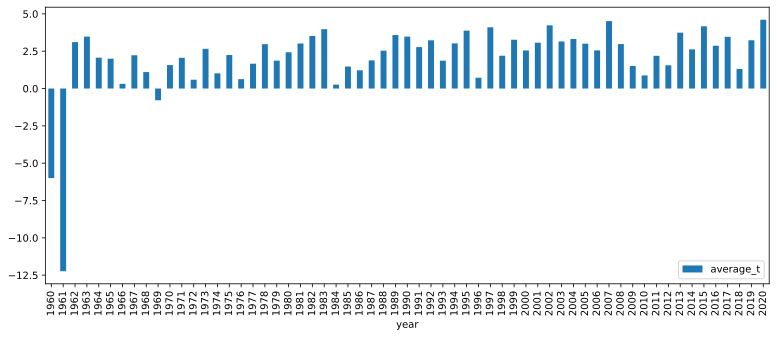

In [59]:
diag1 = temp_8.plot.bar()
diag1.legend(loc=4)

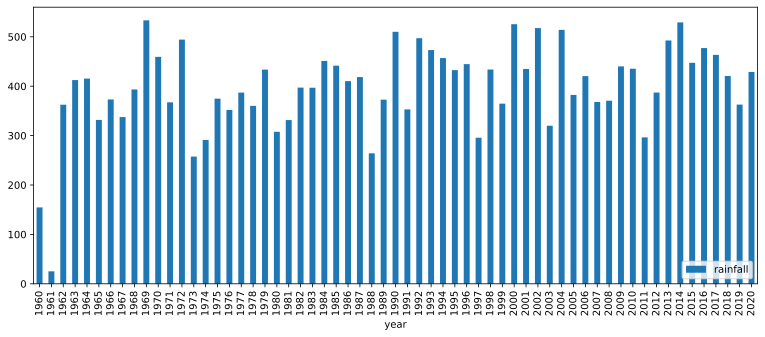

In [60]:
diag2 = rainfall_8.plot.bar()
diag2.legend(loc=4)

In [61]:
print(
    f'самый тёплый год - {temp_8.idxmax()}, самый холодный - {temp_8.idxmin()}')
print(
    f'год максимума осадков - {rainfall_8.idxmax()}, минимума - {rainfall_8.idxmin()}')

самый тёплый год - 2020, самый холодный - 1961
год максимума осадков - 1969, минимума - 1961


9.1 средняя температура ниже -30


In [62]:
print(df[df['average_t'] < -30][['Date', 'average_t']])

            Date  average_t
17    1960-01-18      -31.2
18    1960-01-19      -33.2
1854  1965-01-28      -30.6
1855  1965-01-29      -34.7
2181  1965-12-21      -33.0
...          ...        ...
21585 2019-02-05      -32.0
21588 2019-02-08      -32.8
22275 2020-12-26      -31.6
22276 2020-12-27      -36.3
22277 2020-12-28      -34.2

[230 rows x 2 columns]


9.2 средняя температура выше 27 и количество дней без осадков больше 3


In [63]:
print(df[(df['average_t'] > 27) & (df['Without_rainfall'] > 3)]
      [['Date', 'average_t', 'Without_rainfall']])

            Date  average_t  Without_rainfall
1270  1963-06-24       27.4                 9
2020  1965-07-13       28.3                11
2029  1965-07-22       27.3                20
3472  1969-07-04       28.9                 5
3473  1969-07-05       27.9                 6
5305  1974-07-11       27.8                19
6381  1977-06-21       27.2                22
8601  1983-07-20       27.2                 7
10395 1988-06-17       28.3                 6
11884 1992-07-15       28.0                 7
15563 2002-08-11       28.5                10


In [64]:
# with pd.option_context("display.min_rows", 50, "display.max_rows", 100, \
#    "display.max_columns", 15, 'display.max_colwidth', 150): display(df)